In [1]:
import pandas as pd
import requests
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from microgrid.engine import Network, Bus, Generator, TransmissionLine, Load, StorageUnit
from microgrid.draw import draw_network

pd.set_option('display.max_columns', 100)

In [2]:
r = requests.get('https://data.elexon.co.uk/bmrs/api/v1/reference/bmunits/all')

fuel_types = pd.DataFrame(r.json())

In [3]:
fuel_types.fuelType.value_counts()

fuelType
WIND       238
CCGT        64
OTHER       45
NPSHYD      36
OCGT        22
BIOMASS     18
PS          16
NUCLEAR     16
COAL        10
INTELEC      2
INTGRNL      2
INTVKL       2
INTNED       1
INTFR        1
INTEW        1
INTIFA2      1
INTIRL       1
INTNSL       1
INTNEM       1
Name: count, dtype: int64

In [4]:
df = pd.read_csv('~/Downloads/GenerationByFuelType-2024-04-11T06_30_00.000Z-2025-04-11T06_30_00.000Z.csv')

In [5]:
flattened = df.set_index(['SettlementDate', 'SettlementPeriod', 'FuelType'])['Generation'].unstack().reset_index()
flattened['ts'] = flattened['SettlementDate'] + ' ' + flattened['SettlementPeriod'].astype(str)
flattened = flattened.set_index('ts').drop(['SettlementDate', 'SettlementPeriod'], axis=1)



flattened

demand = flattened.sum(axis=1)

nuclear = flattened['NUCLEAR'].to_list()
wind = flattened['WIND'].to_list()
biomass = flattened['BIOMASS'].to_list()

IC = (-1 * flattened.filter(like='INT').fillna(0).sum(axis=1)).to_list() #Negative because +ve generation means flow out of France


In [ ]:
b1 = Bus(name='National node')

# Load
l1 = Load('Demand', demands=demand.to_list())
b1.add_load(l1)


# Generators
G_nuclear = Generator('Nuclear', capacities=nuclear, costs=[1]*len(flattened))
G_ccgt_cheap = Generator('CCGT_cheap', capacities=[2_000]*len(flattened), costs=[3]*len(flattened))
G_ccgt_medium = Generator('CCGT_medium', capacities=[2_000]*len(flattened), costs=[4]*len(flattened))
G_ccgt_expensive = Generator('CCGT_expensive', capacities=[50_000]*len(flattened), costs=[5]*len(flattened))

G_wind = Generator('Wind', capacities=wind, costs=[0]*len(flattened))
G_biomass = Generator('Biomass', capacities=biomass, costs=[2]*len(flattened))

b1.add_generator(G_nuclear)
b1.add_generator(G_ccgt_cheap)
b1.add_generator(G_ccgt_medium)
b1.add_generator(G_ccgt_expensive)
b1.add_generator(G_wind)
b1.add_generator(G_biomass)


# Interconnectors
b_IC = Bus(name='Europe')
l_IC = Load('IC', demands=IC)
b_IC.add_load(l_IC)

t_IC = TransmissionLine(start_bus=b_IC, end_bus=b1, capacities=[10000]*len(flattened))

# Battery Storage
su_battery = StorageUnit('Batteries', max_soc_capacity=3000, max_charge_capacities=[3000]*len(flattened), max_discharge_capacities=[3000]*len(flattened))
b1.add_storage_unit(su_battery)

su_pumped = StorageUnit('Pumped', max_soc_capacity=10_000, max_charge_capacities=[1000]*len(flattened), max_discharge_capacities=[1000]*len(flattened))
b1.add_storage_unit(su_pumped)

n = Network(name='Single Market', timesteps=demand.index.to_list())
n.add_bus(b1)
n.add_bus(b_IC)
n.add_transmission_line(t_IC)


status = n.solve()



Checking timesteps match accross all components
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/azadave/.local/share/virtualenvs/microgrid-SdKnRwhr/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/70/5frn1zkd3n1bwqk9y5h1_l4h0000gn/T/199fd96d720a422b97436374b3a12e16-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/70/5frn1zkd3n1bwqk9y5h1_l4h0000gn/T/199fd96d720a422b97436374b3a12e16-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 455527 COLUMNS
At line 1314008 RHS
At line 1769531 BOUNDS
At line 2049852 ENDATA
Problem MODEL has 455522 rows, 262800 columns and 770880 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 48417 (-407105) rows, 171975 (-90825) columns and 260521 (-510359) elements
Perturbing problem by 0.001% of 5 - largest nonzero change 1.549991e-06 ( 0.00011499833%) - largest zero ch

<Axes: >

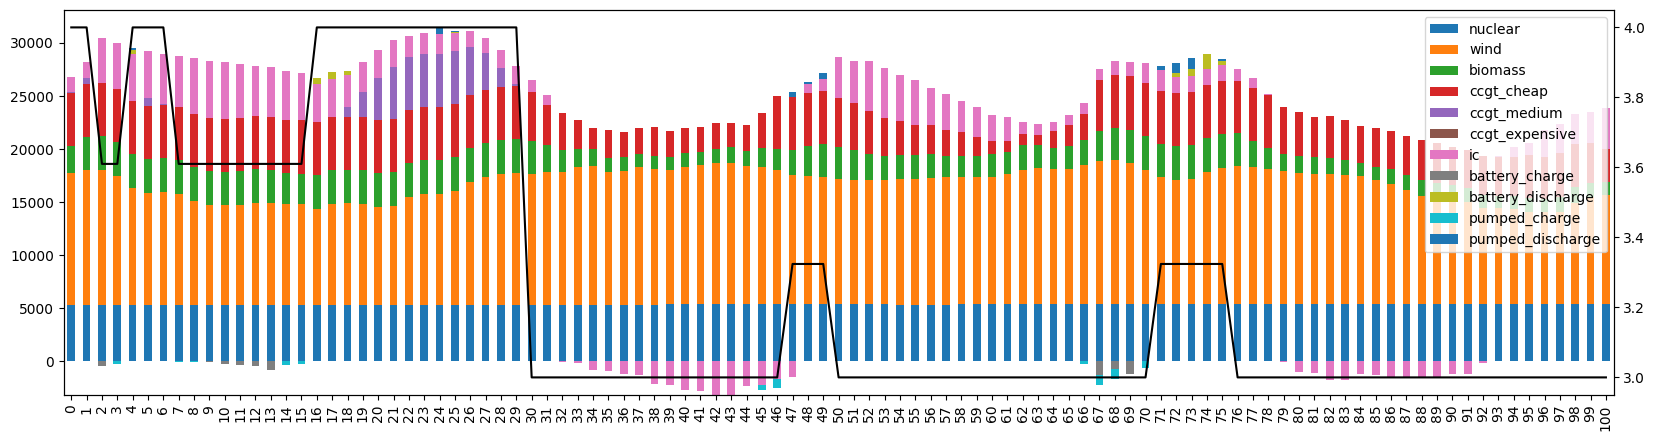

In [19]:
output = pd.DataFrame(
    data = 
    {
    'demand': [o for o in  n.buses[0].loads[0].demands],
    'ccgt_cheap': [o.varValue for o in  n.buses[0].generators[1].outputs],
    'ccgt_medium': [o.varValue for o in  n.buses[0].generators[2].outputs],
    'ccgt_expensive': [o.varValue for o in  n.buses[0].generators[3].outputs],
    'nuclear': [o.varValue for o in  n.buses[0].generators[0].outputs],
    'wind': [o.varValue for o in  n.buses[0].generators[4].outputs],
    'biomass': [o.varValue for o in  n.buses[0].generators[5].outputs],
    'ic': [o.varValue for o in  n.transmission_lines[0].flows],
    'battery_charge': [-o.varValue for o in  n.buses[0].storage_units[0].charge_inflows],
    'battery_discharge': [o.varValue for o in  n.buses[0].storage_units[0].discharge_outflows],

    'pumped_charge': [-o.varValue for o in  n.buses[0].storage_units[1].charge_inflows],
    'pumped_discharge': [o.varValue for o in  n.buses[0].storage_units[1].discharge_outflows],
    'price': [o for o in  n.buses[0].nodal_prices],
    
    })

ax = output.loc[0:100][[
'nuclear', 
'wind',
'biomass', 
'ccgt_cheap', 
'ccgt_medium', 
'ccgt_expensive', 
'ic', 
'battery_charge',
'battery_discharge', 
'pumped_charge',
'pumped_discharge'
]].plot(kind='bar', stacked=True, figsize=(20,5))
ax2 = ax.twinx()

output.loc[0:100]['price'].plot(ax=ax2, color='black')

In [ ]:
output.loc[0:100][['nuclear', 'wind','biomass', 'gas', 'ic', 'battery']].plot(kind='bar', stacked=True, figsize=(20,5))

np.float64(3036.0)

<Axes: xlabel='ts'>

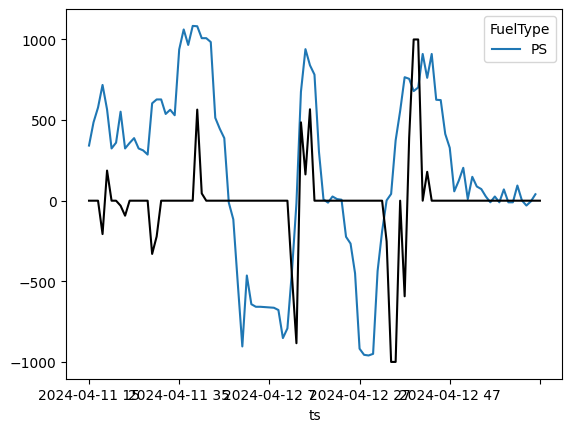

In [23]:
ax = flattened.iloc[0:100][['PS']].plot()
output.loc[0:100][['pumped_charge', 'pumped_discharge']].sum(axis=1).plot(ax=ax, color='black')

dict_keys([(<microgrid.engine.Bus object at 0x14cc89b80>, <microgrid.engine.Bus object at 0x14be707a0>)])

In [92]:
flattened

FuelType,BIOMASS,CCGT,COAL,INTELEC,INTEW,INTFR,INTGRNL,INTIFA2,INTIRL,INTNED,INTNEM,INTNSL,INTVKL,NPSHYD,NUCLEAR,OCGT,OIL,OTHER,PS,WIND
ts,,,,,,,,,,,,,,,,,,,,
2024-04-11 15,2492.0,2905.0,461.0,988.0,-532.0,120.0,NaN,426.0,-450.0,0.0,-84.0,906.0,0.0,531.0,5307.0,109.0,0.0,781.0,342.0,12449.0
2024-04-11 16,3050.0,2727.0,322.0,990.0,-532.0,134.0,NaN,438.0,-450.0,0.0,-24.0,982.0,0.0,693.0,5311.0,189.0,0.0,1147.0,486.0,12755.0
2024-04-11 17,3187.0,2364.0,372.0,998.0,-532.0,778.0,NaN,896.0,-452.0,408.0,786.0,1356.0,0.0,572.0,5311.0,83.0,0.0,555.0,578.0,12733.0
2024-04-11 18,3207.0,2366.0,435.0,998.0,-532.0,812.0,NaN,920.0,-452.0,412.0,818.0,1394.0,0.0,551.0,5310.0,80.0,0.0,643.0,718.0,12123.0
2024-04-11 19,3194.0,3033.0,396.0,998.0,-532.0,996.0,NaN,988.0,-452.0,0.0,998.0,1396.0,0.0,530.0,5314.0,130.0,0.0,990.0,566.0,11009.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-11 10,2958.0,5883.0,0.0,996.0,-398.0,1004.0,-514.0,992.0,-450.0,-778.0,466.0,698.0,1424.0,46.0,4468.0,0.0,0.0,292.0,-668.0,4945.0
2025-04-11 11,2958.0,6240.0,0.0,996.0,-258.0,1004.0,-514.0,992.0,-388.0,-1032.0,10.0,698.0,1424.0,87.0,4466.0,1.0,0.0,348.0,-174.0,4827.0
2025-04-11 12,2956.0,7242.0,0.0,996.0,-206.0,984.0,-514.0,992.0,-448.0,-1032.0,0.0,698.0,1424.0,114.0,4470.0,1.0,0.0,425.0,-80.0,4913.0
